In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import random
random.seed(10)

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from distributed import Client
from tune import Space, Grid, Rand, RandInt, Choice
from tune_sklearn import sk_space, suggest_sk_models, suggest_sk_models_by_cv

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

In [3]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

In [4]:
import warnings
warnings.filterwarnings('ignore')

## *Load Cleaned Data using DASK*

In [5]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [6]:
import dask.dataframe as dd
%time df = dd.read_csv('04_Pre_Processed.csv') 

Wall time: 14 ms


In [7]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_CITY_NAME,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_CITY_NAME,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,DEP_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DIV_AIRPORT_LANDINGS,FLIGHT_COUNT,PRIOR_ORIGIN_CITY_NAME,PRIOR_DELAY,PRIOR_DEP_DELAY,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,BEGINING_OF_MONTH,MIDDLE_OF_MONTH,END_OF_MONTH,HOUR,MORNING,DAY,EVENING,NIGHT,WINTER,SPRING,SUMMER,AUTUMN,WEEKEND,WEEKDAY,DEPTIME_COS,DEPTIME_SIN,CRS_DEPTIME_COS,CRS_DEPTIME_SIN
0,2019,1,1,1,2,7,0,1670,252,12,7,33,263,17,11,41,0.0,0.0,0.0,166.0,0,1,220,0.0,0.0,0,1,0,1,0,1,1,0,0,4,0,0,0,1,1,0,0,0,0,1,0.854912,-0.518773,0.843391,-0.537300
1,2019,1,1,1,2,7,0,1671,263,17,11,41,252,12,7,33,1.0,0.0,0.0,161.0,0,2,252,0.0,-5.0,0,1,0,1,0,1,1,0,0,6,0,0,0,1,1,0,0,0,0,1,0.143493,-0.989651,0.337917,-0.941176
2,2019,1,1,2,3,7,0,890,299,12,7,33,105,18,12,42,0.0,0.0,0.0,142.0,0,1,220,0.0,0.0,0,0,0,0,0,0,1,0,0,3,0,0,0,1,1,0,0,0,0,1,0.995396,-0.095846,0.991445,-0.130526
3,2019,1,1,2,3,7,0,891,105,18,12,42,299,12,7,33,0.0,0.0,0.0,138.0,0,2,298,0.0,-8.0,0,0,0,0,0,0,1,0,0,5,0,0,0,1,1,0,0,0,0,1,0.612217,-0.790690,0.584250,-0.811574
4,2019,1,1,2,3,7,0,1203,299,12,7,33,14,37,31,36,0.0,0.0,0.0,94.0,0,3,105,0.0,-8.0,0,0,0,0,0,0,1,0,0,7,1,0,0,0,1,0,0,0,0,1,-0.292372,-0.956305,-0.317305,-0.948324


In [8]:
df.compute().shape

(1705725, 49)

In [9]:
df['DEP_DEL15'].compute().value_counts(normalize = True)

0.0    0.814386
1.0    0.185614
Name: DEP_DEL15, dtype: float64

### *Scalable Hyperparameter Tuning - Fugue & Tune*

In [10]:
dft = df.compute().rename({'DEP_DEL15': 'label'}, axis='columns')

In [11]:
type(dft)

pandas.core.frame.DataFrame

In [12]:
dft = dft.sample(frac = 1)
dft.shape

(1705725, 49)

In [13]:
space = sum([
    sk_space(RandomForestClassifier,
             random_state=42,
             criterion = Grid('entropy', 'gini'), 
             max_depth = Rand(5, 8, 10), 
             max_features = Grid('auto', 'sqrt'),
             min_samples_leaf = Rand(4, 6, 8),
             min_samples_split = Rand(5, 7,10),
             n_estimators = Grid(100, 200, 300),
             n_jobs = -1),
    sk_space(LogisticRegression, 
             random_state=42,
             C = Grid(0.001,0.01, 0.1, 1)),
    sk_space(SVC(), 
             random_state=42,
             C = Grid(0.1, 1, 10, 100, 1000), 
             gamma = Rand(0.0001, 0.001, 0.01, 0.1, 1),
             kernel = 'rbf'),
    sk_space(GradientBoostingClassifier(),
             random_state=42,
             max_depth=8, min_samples_split=2, max_features='sqrt',
             learning_rate = Rand(0.001, 0.005, 0.01, 0.05, 0.1),
             n_estimators = Grid(100,300,500)),
    sk_space(AdaBoostClassifier(),
            random_state = 42,
            learning_rate = Rand(0.05, 0.5),
            n_estimators = Rand(100, 300))
])

In [14]:
len(list(space))

25

In [15]:
list(space)

[{'__space__model': 'sklearn.ensemble._forest.RandomForestClassifier',
  'random_state': 42,
  'criterion': 'entropy',
  'max_depth': <tune.space.parameters.Rand at 0x20b17dee8e0>,
  'max_features': 'auto',
  'min_samples_leaf': <tune.space.parameters.Rand at 0x20b17dee400>,
  'min_samples_split': <tune.space.parameters.Rand at 0x20b17dee5b0>,
  'n_estimators': 100,
  'n_jobs': -1},
 {'__space__model': 'sklearn.ensemble._forest.RandomForestClassifier',
  'random_state': 42,
  'criterion': 'entropy',
  'max_depth': <tune.space.parameters.Rand at 0x20b17df40a0>,
  'max_features': 'auto',
  'min_samples_leaf': <tune.space.parameters.Rand at 0x20b17df41f0>,
  'min_samples_split': <tune.space.parameters.Rand at 0x20b17df4280>,
  'n_estimators': 200,
  'n_jobs': -1},
 {'__space__model': 'sklearn.ensemble._forest.RandomForestClassifier',
  'random_state': 42,
  'criterion': 'entropy',
  'max_depth': <tune.space.parameters.Rand at 0x20b17df4370>,
  'max_features': 'auto',
  'min_samples_leaf':

### Hyperparameter tuning - 'roc_auc'

In [16]:
%time result = suggest_sk_models_by_cv(space, train_df = dft, cv = 5, temp_path = r"C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\18_ML_Modeling\Capstone2", scoring="roc_auc")

#suggest_sk_models_by_cv(space, train_df, scoring, cv, temp_path, feature_prefix, label_col, 
#                        save_model, partition_keys, top_n, objective_runner, monitor, distributed, 
#                        execution_engine, execution_engine_conf)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Wall time: 13min 43s


In [17]:
for r in result:
    print(r.metric, r.trial.keys, r.trial.params)

0.7473615186393974 [] {'C': 0.01, '__space__model': 'sklearn.linear_model._logistic.LogisticRegression', 'random_state': 42}


### Hyperparameter tuning  - 'average_precision'

In [18]:
%time result_ap = suggest_sk_models_by_cv(space, train_df = dft, cv = 5, temp_path = r"C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\18_ML_Modeling\Capstone2", scoring="average_precision")

#suggest_sk_models_by_cv(space, train_df, scoring, cv, temp_path, feature_prefix, label_col, 
#                        save_model, partition_keys, top_n, objective_runner, monitor, distributed, 
#                        execution_engine, execution_engine_conf)

NativeExecutionEngine doesn't respect num_partitions ROWCOUNT


Wall time: 13min 57s


In [19]:
for r in result_ap:
    print(r.metric, r.trial.keys, r.trial.params)

0.5172911648832308 [] {'C': 1, '__space__model': 'sklearn.linear_model._logistic.LogisticRegression', 'random_state': 42}


## *Modeling*

In [20]:
X = df.drop('DEP_DEL15', axis = 1)
y = df['DEP_DEL15']

### *Train-Test Split*

In [21]:
# Splitting the data
from dask_ml.model_selection import train_test_split
%time X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, shuffle=True)

Wall time: 5.59 ms


### *Standardization*

In [22]:
# Standardize data before modeling
from dask_ml.preprocessing import StandardScaler
sc = StandardScaler()
%time X_train = sc.fit_transform(X_train)
%time X_test = sc.transform(X_test)

Wall time: 4.38 s
Wall time: 14 ms


In [23]:
%time X_train = X_train.persist()
%time X_test = X_test.persist()
%time y_train = y_train.persist()
%time y_test = y_test.persist()

Wall time: 3.79 s
Wall time: 3.66 s
Wall time: 2.46 s
Wall time: 2.65 s


In [24]:
type(X_train)

dask.dataframe.core.DataFrame

## *Hyperparameter Tuning using Dask*

### *Logistic Regression*

In [25]:
# start a local Dask client
client1 = Client(n_workers=4, 
                threads_per_worker=2,
                memory_limit='128GB') 

In [26]:
client1

Client Scheduler: tcp://127.0.0.1:50505 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.66 GB


In [27]:
import joblib
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


lr = LogisticRegression(class_weight = 'balanced')
pca = PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('lr', lr)])

# Create the grid parameters 'lr__penalty': ['l1', 'l2'],
params = { 
    'pca__n_components': [5, 15, 20, 30],
    'lr__C':[0.001,0.01, 0.1, 1]
}


lr_grid = GridSearchCV(pipe, params, n_jobs = -1)


with joblib.parallel_backend('dask'):
    %time _ = lr_grid.fit(X_train, y_train)

Wall time: 1min 30s


In [28]:
client1.close()

In [29]:
lr_grid.best_params_

{'lr__C': 1, 'pca__n_components': 15}

In [30]:
lr_grid_best = lr_grid.best_estimator_

In [31]:
# Calculating average precision score for X_train
apc_lr_train = average_precision_score(y_train, lr_grid_best.predict_proba(X_train)[:, 1])

# Calculating average precision score for X_test
apc_lr_test = average_precision_score(y_test, lr_grid_best.predict_proba(X_test)[:, 1])

print(f'Train Average Precision Score:{apc_lr_train}')
print(f'Test Average Precision Score:{apc_lr_test}')

Train Average Precision Score:0.5165968126931761
Test Average Precision Score:0.5195719135565113


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.52')

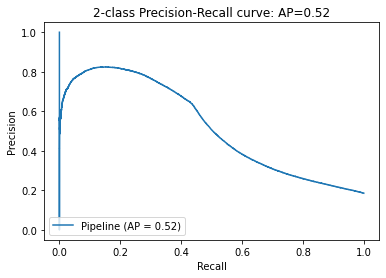

In [32]:
disp = plot_precision_recall_curve(lr_grid_best, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(apc_lr_test))

In [33]:
# Calculating AUC score for X_train
y_pred_lr_train = lr_grid_best.predict(X_train)
fpr_lr_train, tpr_lr_train, thresholds_lr_train = roc_curve(y_train, y_pred_lr_train)
auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

# Calculating AUC score for X_test
y_pred_lr_test = lr_grid_best.predict(X_test)
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, y_pred_lr_test)
auc_lr_test = auc(fpr_lr_test, tpr_lr_test)                                                       

print(f'Train AUC Score:{auc_lr_train}')
print(f'Test AUC Score:{auc_lr_test}')

Train AUC Score:0.6908018874183756
Test AUC Score:0.6927829047907148


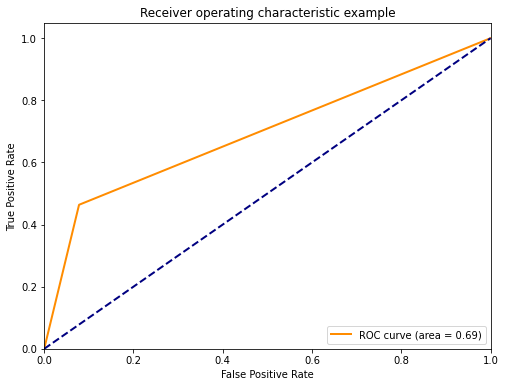

In [34]:
plt.figure(figsize = (8, 6))
lw = 2
plt.plot(fpr_lr_test, tpr_lr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' %auc_lr_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

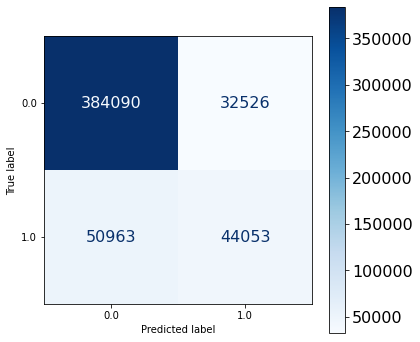

In [35]:
fig, ax = plt.subplots(figsize = (6,6))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(lr_grid_best, X_test, y_test, cmap=plt.cm.Blues, ax = ax, values_format = '') 
plt.show()

In [36]:
print(classification_report(y_test, y_pred_lr_test))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90    416616
         1.0       0.58      0.46      0.51     95016

    accuracy                           0.84    511632
   macro avg       0.73      0.69      0.71    511632
weighted avg       0.83      0.84      0.83    511632



In [37]:
roc_auc_score(y_test, lr_grid_best.predict_proba(X_test)[:, 1])

0.7524474169794839

### *RandomForestClassifier*

In [38]:
# start a local Dask client
client = Client(n_workers=4,
                threads_per_worker=2,
                memory_limit='128GB') 

In [39]:
client #client.get_versions(check=True)

Client Scheduler: tcp://127.0.0.1:50580 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.66 GB


In [40]:
import dask_ml.model_selection as dcv
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


rf = RandomForestClassifier(class_weight = 'balanced')
pca = PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('rf', rf)])

# Create the parameter grid based on the results of random search 'bootstrap': [True, False],
params = {
    'pca__n_components': [10, 20, 30],
    'rf__max_depth': [5, 8],
    'rf__min_samples_leaf': [2, 5],
    'rf__min_samples_split': [2, 5],
    'rf__n_estimators': [100, 300]}


rf_grid = dcv.GridSearchCV(pipe, params, cv = 3, n_jobs = -1)

import joblib
with joblib.parallel_backend('dask'):
    %time rf_grid.fit(X_train, y_train)

Wall time: 6h 47min 2s


In [41]:
client.close()

In [42]:
rf_grid.best_params_

{'pca__n_components': 20,
 'rf__max_depth': 8,
 'rf__min_samples_leaf': 5,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 300}

In [43]:
rf_grid_best = rf_grid.best_estimator_

In [44]:
# Calculating average precision score for X_train
apc_rf_train = average_precision_score(y_train, rf_grid_best.predict_proba(X_train)[:, 1])

# Calculating average precision score for X_test
apc_rf_test = average_precision_score(y_test, rf_grid_best.predict_proba(X_test)[:, 1])

print(f'Train Average Precision Score:{apc_rf_train}')
print(f'Test Average Precision Score:{apc_rf_test}')

Train Average Precision Score:0.5482098340913186
Test Average Precision Score:0.5445413690093149


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.54')

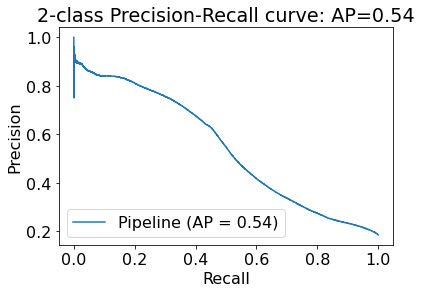

In [45]:
disp = plot_precision_recall_curve(rf_grid_best, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(apc_rf_test))

In [46]:
# Calculating AUC score for X_train
y_pred_rf_train = rf_grid_best.predict(X_train)
fpr_rf_train, tpr_rf_train, thresholds_rf_train = roc_curve(y_train, y_pred_rf_train)
auc_rf_train = auc(fpr_rf_train, tpr_rf_train)

# Calculating AUC score for X_test
y_pred_rf_test = rf_grid_best.predict(X_test)
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(y_test, y_pred_rf_test)
auc_rf_test = auc(fpr_rf_test, tpr_rf_test)                                                       

print(f'Train AUC Score:{auc_rf_train}')
print(f'Test AUC Score:{auc_rf_test}')

Train AUC Score:0.7018987159350695
Test AUC Score:0.7015867434102367


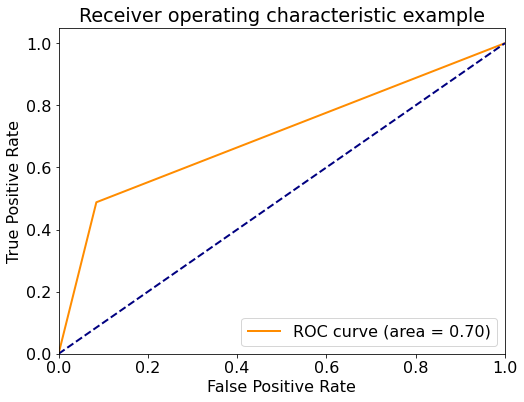

In [47]:
plt.figure(figsize = (8, 6))
lw = 2
plt.plot(fpr_rf_test, tpr_rf_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' %auc_rf_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

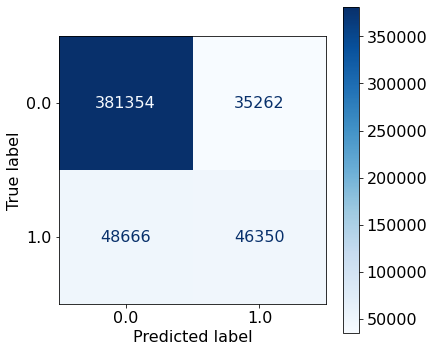

In [48]:
fig, ax = plt.subplots(figsize = (6,6))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(rf_grid_best, X_test, y_test, cmap=plt.cm.Blues, ax = ax, values_format = '') 
plt.show()

In [49]:
print(classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90    416616
         1.0       0.57      0.49      0.52     95016

    accuracy                           0.84    511632
   macro avg       0.73      0.70      0.71    511632
weighted avg       0.83      0.84      0.83    511632



In [50]:
roc_auc_score(y_test, rf_grid_best.predict_proba(X_test)[:, 1])

0.7717954154020784

### *AdaBoostClassifier*

In [51]:
# start a local Dask client
client3 = Client(n_workers=4, 
                threads_per_worker=2,
                memory_limit='128GB') 

In [52]:
client3

Client Scheduler: tcp://127.0.0.1:53373 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.66 GB


In [53]:
import dask_ml.model_selection as dcv
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('ab', ab)])

# Create the parameter grid based on the results of random search 'bootstrap': [True, False],
params = {
    'pca__n_components': [10, 20, 30],
    'ab__learning_rate': [0.05, 0.5],
    'ab__n_estimators': [100, 300]}

ab_grid = dcv.GridSearchCV(pipe, params, cv = 3, n_jobs = -1)

import joblib
with joblib.parallel_backend('dask'):
    %time ab_grid.fit(X_train, y_train)

Wall time: 3h 9min 55s


In [54]:
client3.close()

In [55]:
ab_grid.best_params_

{'ab__learning_rate': 0.5, 'ab__n_estimators': 300, 'pca__n_components': 30}

In [56]:
ab_grid_best = ab_grid.best_estimator_

In [57]:
# Calculating average precision score for X_train
apc_ab_train = average_precision_score(y_train, ab_grid_best.predict_proba(X_train)[:, 1])

# Calculating average precision score for X_test
apc_ab_test = average_precision_score(y_test, ab_grid_best.predict_proba(X_test)[:, 1])

print(f'Train Average Precision Score:{apc_ab_train}')
print(f'Test Average Precision Score:{apc_ab_test}')

Train Average Precision Score:0.5663785827157962
Test Average Precision Score:0.5670439387400201


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.57')

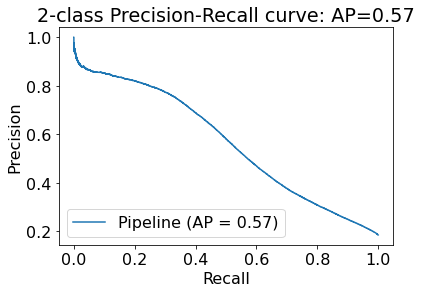

In [58]:
disp = plot_precision_recall_curve(ab_grid_best, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(apc_ab_test))

In [59]:
# Calculating AUC score for X_train
y_pred_ab_train = ab_grid_best.predict(X_train)
fpr_ab_train, tpr_ab_train, thresholds_ab_train = roc_curve(y_train, y_pred_ab_train)
auc_ab_train = auc(fpr_ab_train, tpr_ab_train)

# Calculating AUC score for X_test
y_pred_ab_test = ab_grid_best.predict(X_test)
fpr_ab_test, tpr_ab_test, thresholds_ab_test = roc_curve(y_test, y_pred_ab_test)
auc_ab_test = auc(fpr_ab_test, tpr_ab_test)                                                       

print(f'Train AUC Score:{auc_ab_train}')
print(f'Test AUC Score:{auc_ab_test}')

Train AUC Score:0.6645545293953943
Test AUC Score:0.6651941512612308


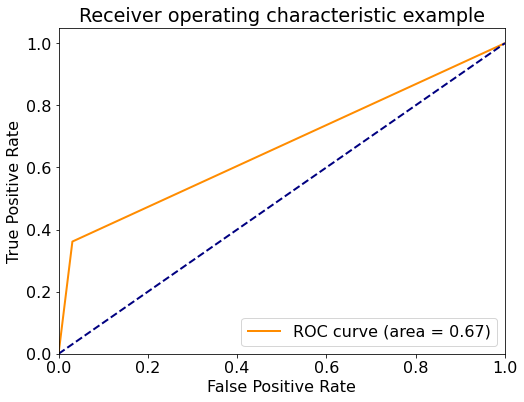

In [60]:
plt.figure(figsize = (8, 6))
lw = 2
plt.plot(fpr_ab_test, tpr_ab_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_ab_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

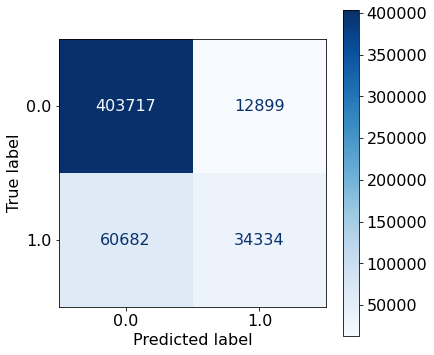

In [61]:
fig, ax = plt.subplots(figsize = (6,6))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(ab_grid_best, X_test, y_test, cmap=plt.cm.Blues, ax = ax, values_format = '') 
plt.show()

In [62]:
print(classification_report(y_test, y_pred_ab_test))

              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92    416616
         1.0       0.73      0.36      0.48     95016

    accuracy                           0.86    511632
   macro avg       0.80      0.67      0.70    511632
weighted avg       0.84      0.86      0.84    511632



#### *Avergae Precision Score*

*5-10 PCA components*

| Classifier | Train Score | Test Score |
| --- | --- | --- |
| **Logistic Resgression** | **0.5166** | **0.5196** |
| RandomForestClassifier | 0.4384 | 0.4347 |
| AdaBoostClassifier | 0.4281 | 0.4282 |

*5-30 PCA components*

| Classifier | Train Score | Test Score |
| --- | --- | --- |
| Logistic Resgression | 0.5166 | 0.5196 |
| RandomForestClassifier | 0.5482 | 0.5445 |
| **AdaBoostClassifier** | **0.5664** | **0.5670** |

#### *AUC Score*

*5-10 PCA components*

| Classifier | Train Score | Test Score |
| --- | --- | --- |
| **Logistic Resgression** | **0.6908** | **0.6927** |
| RandomForestClassifier | 0.6649 | 0.6644 |
| AdaBoostClassifier | 0.5465 | 0.5457 |

*5-30 PCA components*

| Classifier | Train Score | Test Score |
| --- | --- | --- |
| Logistic Resgression | 0.6908 | 0.6928 |
| **RandomForestClassifier** | **0.7019** | **0.7159** |
| AdaBoostClassifier | 0.6645 | 0.6652 |

All the models used to train the data have outperformed the base line. The best suggested model by using Tune is Logitic Regression and Dask is AdaBoost Classifier. Considering average precision as metric since target classes are imbalanced.  

### *Feature Importances*

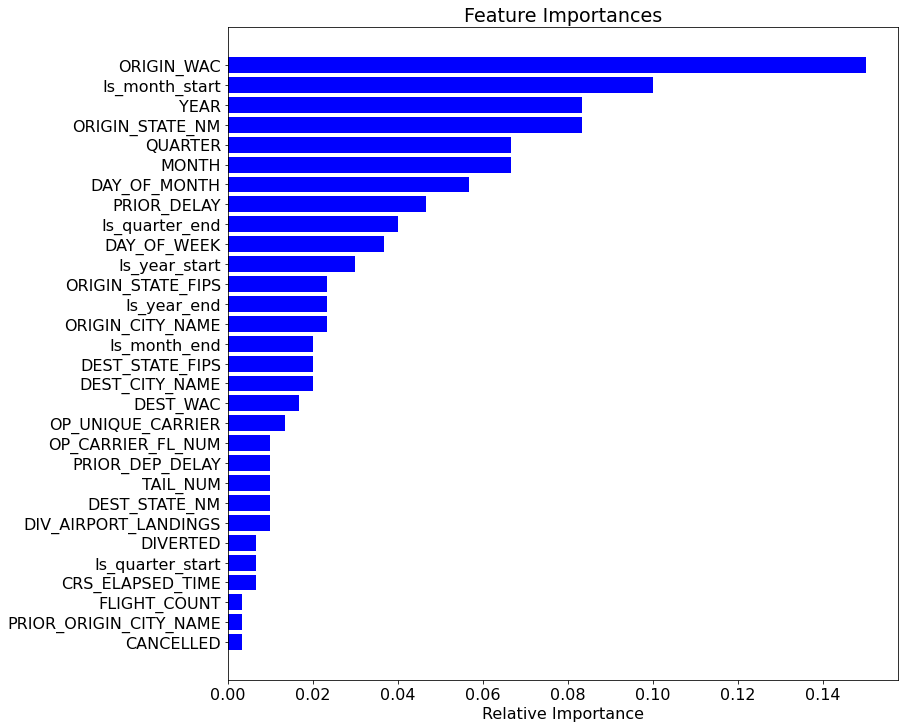

In [71]:
features = X_train.columns
importances = ab_grid_best._final_estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Conclusions:

The dataset used for the project contains local flight data for the months January, February and March for the year 2019, does not take into considerations any weather conditions or natural calamities into account. 

Next Steps:

we plan to identify the significance of each feature by using stats models. Also, according to the Federal Aviation Administration, most of the delays in winter are due to surface winds, low ceiling and low visibility, whereas during summer the majority of delays is attributable to convective weather, low ceiling and associated low visibility (Federal Aviation Administration, 2017). It will be wise to include daily weather data, like wind, speed and precipitation rate, for each origin and destination location for each flight.